# Running EM on the birdsong corpus

## Getting set up

In [26]:
import markhov
import em
import numpy as np
import pandas as pd
%pylab inline
import seaborn as sns
from florisplotlib import *

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Read in the birdsong corpus

In [2]:
f=open('../corpus/cath8.txt','r')
corpus = f.readlines()
f.close()
corpus = [line.rstrip('\n') for line in corpus]


Create a transition grammar for the corpus

In [3]:
trans = {'[':[]}
for s in corpus:
    s=['[']+s.split(' ')
    for i in range(1,len(s)):
        trans[s[i-1]]=trans.get(s[i-1],[])
        if s[i] not in trans[s[i-1]]:
            trans[s[i-1]].append(s[i])


Operations FSA

In [4]:
ops = {'S':[('NotCL','mg')], # from start we have to merge
       'NotCL':[('NotCL','mg'),('NotCL','copy'), # this state is the state in which the last "special" operation was *not* Clear. Either we've done none or the last was copy. From here we can do everything including end
               ('CLEAR_S','clear'), # go here to clear the buffer
               ('F','end') # go here to end
           ],
       'CLEAR_S':[('CLEAR','mg')], # this is where we've just cleared. Buffer is empty so you can only Merge
       'CLEAR':[('CLEAR','mg'), # the last special op was Clear so we can Copy or Merge.
                ('NotCL','copy') # if we Copy, the last special op was Copy so go to NotCL
            ],
       'F':[] #final state
   }


## Expectation Maximisation time!

In [5]:
n = 10 # number of EM iterations to do

In [6]:
history=em.em(corpus,trans,ops,n) # run EM

### Display the results

Make the rules into a simpler list

In [7]:
rules=[]
for lhs in ops:
    for (rhs,e) in ops[lhs]:
        rules.append(('%s->%s %s'%(lhs,e,rhs),(lhs,rhs,e)))

Put them and their updating probabilities into a table

In [33]:
tab=[]
for (rule,(lhs,rhs,e)) in rules:
    thisrule={' rule':rule}
    for i in range(n):
        p=history[i]['fsa'][lhs][(rhs,e)]
        thisrule["p.iteration%03d"%i]=p
    tab.append(thisrule)

Use pandas to make the table into a datafram

In [34]:
df = pd.DataFrame(tab)

In [35]:
df

,rule,p.iteration000,p.iteration001,p.iteration002,p.iteration003,p.iteration004,p.iteration005,p.iteration006,p.iteration007,p.iteration008,p.iteration009
0,S->mg NotCL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,CLEAR->mg CLEAR,-0.717448,-0.959753,-1.061424,-1.212408,-1.401463,-1.530414,-1.604865,-1.799762,-2.009474,-2.198328
2,CLEAR->copy NotCL,-0.669423,-0.482866,-0.424591,-0.353082,-0.282677,-0.243915,-0.224290,-0.180729,-0.143939,-0.117645
3,CLEAR_S->mg CLEAR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,NotCL->mg NotCL,-3.793819,-0.547657,-0.364201,-0.261078,-0.209839,-0.185829,-0.173513,-0.165592,-0.161284,-0.158743
5,NotCL->copy NotCL,-2.639774,-3.104462,-3.797288,-4.478197,-5.025962,-5.485364,-5.946820,-6.468045,-7.046852,-7.832659
6,NotCL->clear CLEAR_S,-0.567130,-1.737558,-2.225404,-2.805069,-3.401176,-3.925724,-4.364821,-4.796188,-5.132561,-5.391818
7,NotCL->end F,-1.081866,-1.604954,-1.744154,-1.845651,-1.901221,-1.926139,-1.938201,-1.946350,-1.950673,-1.953097


In [36]:
df.to_csv('ops_%s.csv'%('oct_23_2016_cath8')) # print to file

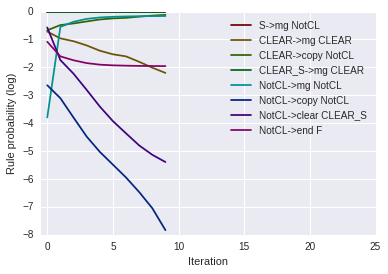

In [37]:
ncol,_ = df.shape
colors = get_colors(ncol)
for i,row in df.iterrows():
    col = colors[i]
    plot(range(n),[ row["p.iteration%03d"%i] for i in range(n) ],'-',color=col,label=row[" rule"])
legend()
xlim(-.5,n+15)
xlabel("Iteration")
ylabel("Rule probability (log)")

Same for the transitions

In [38]:
bigrams=[]
for lhs in trans:
    for rhs in trans[lhs]:
        bigrams.append(('%s,%s'%(lhs,rhs),(lhs,rhs)))

In [48]:
tab=[]
for (bi,(lhs,rhs)) in bigrams:
    thisrule={' bigram':bi}
    for i in range(n):
        p=history[i]['trans_probs'][lhs][rhs]
        thisrule["p.iteration%03d"%i]=p
    tab.append(thisrule)

In [49]:
df_bis = pd.DataFrame(tab)

In [50]:
df_bis

,bigram,p.iteration000,p.iteration001,p.iteration002,p.iteration003,p.iteration004,p.iteration005,p.iteration006,p.iteration007,p.iteration008,p.iteration009
0,"aua,aiz",-2.943601,-2.454481,-2.531159,-2.654949,-2.878802,-2.979295,-3.003056,-3.012521,-3.018023,-3.020980
1,"aua,ats",-1.966475,-0.508544,-0.502800,-0.604598,-0.814502,-0.906880,-0.927616,-0.935525,-0.939967,-0.942313
2,"aua,aua",-2.585201,-3.635816,-2.988243,-1.903390,-1.159643,-0.978272,-0.943099,-0.929982,-0.922639,-0.918770
3,"aua,amb",-2.551616,-2.859946,-2.936624,-3.060414,-3.284267,-3.384760,-3.408521,-3.417986,-3.423488,-3.426445
4,"aua,aje",-2.407207,-3.553093,-3.629771,-3.753561,-3.977414,-4.077907,-4.101669,-4.111133,-4.116635,-4.119592
5,"aua,aiy",-2.046083,-2.859946,-2.936624,-3.060414,-3.284267,-3.384760,-3.408521,-3.417986,-3.423488,-3.426445
6,"aua,aib",-1.938714,-3.553093,-3.629771,-3.753561,-3.977414,-4.077907,-4.101669,-4.111133,-4.116635,-4.119592
7,"aua,ban",-3.962153,-3.553093,-3.629771,-3.753561,-3.977414,-4.077907,-4.101669,-4.111133,-4.116635,-4.119592
8,"aua,awi",-2.409296,-3.553093,-3.629771,-3.753561,-3.977414,-4.077907,-4.101669,-4.111133,-4.116635,-4.119592
9,"aua,abu",-2.002460,-3.553093,-3.629771,-3.753561,-3.977414,-4.077907,-4.101669,-4.111133,-4.116635,-4.119592


In [51]:
df_bis.to_csv('trans_%s.csv'%('oct_23_2016_cath8'))

### Calculate the log likelihood of the corpus given the trained grammar

This is the ll of the corpus at the end of training:

In [52]:
# parse the corpus
parsed_corpus=em.parse_corpus(corpus,trans,ops)

In [53]:
em.ll_corpus(parsed_corpus,history[-1]['trans_probs'],history[-1]['fsa'])

-4689.6937170239644

Make a dataframe of the LL of the corpus throughout training:

In [54]:
tab=[]
for i in range(n):
    this_iter={'iteration':i,
               'likelihood':em.ll_corpus(parsed_corpus,history[i]['trans_probs'],history[i]['fsa'])}
    tab.append(this_iter)

In [55]:
df_lls=pd.DataFrame(tab)

In [56]:
df_lls

,iteration,likelihood
0,0,-9666.014708
1,1,-5116.676252
2,2,-4926.957422
3,3,-4815.998511
4,4,-4756.613238
5,5,-4729.088623
6,6,-4707.003046
7,7,-4697.834229
8,8,-4692.543897
9,9,-4690.437577


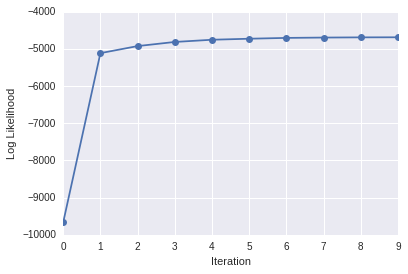

In [57]:
plot(df_lls["iteration"],df_lls["likelihood"],'o-')
xlabel("Iteration")
ylabel("Log Likelihood")